# Aragon Conviction Voting Model - Version 3

New to this version 3  model are the following elements:

* Adding the realism that not all participant tokens are being allocated to proposals at each timestep.
* Refactored parameters and system initialization to make more readable and consistent.
* Changed file structure and file names to align with emerging cadCAD standards.
* Making the distinction between effective and total supply.
* Refining alpha calculations to more accurately reflect the 1Hive implementation. Discussion of alpha and its relation to alpha in the contract and how it relates to the timescales
* Updated differential specification and write-up to respect new state variables
* Moved all unit denominations to Honey, the 1Hive governance token.
* Added system health metrics


# An Introduction to Conviction Voting

Conviction Voting is an approach to organizing a communities preferences into discrete decisions in the management of that communities resources. Strictly speaking conviction voting is less like voting and more like signal processing. Framing the approach and the initial algorithm design was done by Michael Zargham and published in a short research proposal [Social Sensor Fusion](https://github.com/BlockScience/conviction/blob/master/social-sensorfusion.pdf). This work is based on a dynamic resource allocation algorithm presented in Dr. Zargham's PhD Thesis.

The work proceeded in collaboration with the Commons Stack, including expanding on the python implementation to makeup part of the Commons Simulator game. An implemention of Conviction Voting as a smart contract within the Aragon Framework was developed by 1Hive.org and is currently being used for community decision making for allocations of their community currency, Honey.


## The Word Problem

Suppose a group of people want to coordinate to make a collective decision. Social dynamics such as discussions, signaling, and even changing ones mind based on feedback from others input play an important role in these processes. While the actual decision making process involves a lot of informal processes, in order to be fair the ultimate decision making process still requires a set of formal rules that the community collecively agrees to, which serves to functionally channel a plurality of preferences into a discrete outcomes. In our case we are interested in a procedure which supports asynchronous interactions, an provides visibility into likely outcomes prior to their resolution to serve as a driver of good faith, debate and healthy forms of coalition building. Furthermore, participations should be able to show support for multiple initiatives, and to vary the level of support shown. Participants have a quantity of signaling power which may be fixed or variable, homogenous or heterogenous. For the purpose of this document, we'll focus on the case where the discrete decisions to be made are decisions to allocate funds from a shared funding pool towards projects of interest to the community.

## Converting to a Math Problem

Let's start taking these words and constructing a mathematical representation that supports a design that meets the description above. To start we need to define participants.

### Participants
Let $\mathcal{A}$ be the set of participants. Consider a participant $a\in \mathcal{A}$. Any participant $a$ has some capacity to participate in the voting process through their token holdings $h[a]$. In a homogenous fixed token quantity system (like you might see in a democratic allocation of equal tokens per each participant), $h[a] = h$ for all $a\in \mathcal{A}$ where $h$ is a constant. The access control process managing how one becomes a participant determines the total supply of "votes" $S = \sum_{a\in \mathcal{A}} = n\cdot h$ where the number of participants is $n = |\mathcal{A}|$. In a smart contract setting, the set $\mathcal{A}$ is a set of addresses, and $h[a]$ is a quantity of tokens held by each address $a\in \mathcal{A}$. 

### Proposals & Shared Resources
Next, we introduce the idea of proposals.  Consider a proposal $i\in \mathcal{C}$. Any proposal $i$ is associated with a request for resources $r[i]$. Those requested resources would be allocated from a constrained pool of communal resources currently totaling $R$. The pool of resources may become depleted because when a proposal $i$ passes the reserve is decremented by $R^+= R-r[i]$. Therefore it makes sense for us to consider what fraction of the shared resources are being request $\mu_i = \frac{r[i]}{R}$, which means that thre resource depletion from passing proposals can be bounded by requiring $\mu_i < \mu$ where $\mu$ is a constant representing the maximum fraction of the shared resources which can be dispersed by any one proposal. In order for the system to be sustainable a source of new resources is required. In the case where $R$ is funding, new funding can come from revenues, donations, or in some DAO use cases minting tokens.

### Participants Preferences for Proposals

Most of the interesting information in this system is distributed amongst the participants and it manifests as preferences over the proposals. This can be visualized as a matrix $W\in \mathbb{R}^{n \times m}$, with participants holding randomized affinities from -1 to +1 over all proposals.
![](https://i.imgur.com/Rk2BYKd.png)

These private hidden signals drive discussions and voting actions. Each participant individually decides how to allocate their votes across the available proposals. Participant $a$ supports proposal $i$ by setting $x[a,i]>0$ but they are limited by their total token holdings $\sum_{k\in \mathcal{C}} x[a,k] \le h[a]$.  Assuming each participant chooses a subset of the proposals to support, a support graph is formed.
![](https://i.imgur.com/KRh8tKn.png)

## Aggregating Information

In order to break out of the synchronous ad hoc voting model, a dynamical systems model of this system is introduced, which is explored further below.

### Participants Allocate Voting Power
![](https://i.imgur.com/DZRDwk6.png)

In the above diagram, we examine the participant view. Participant $a$ with holdings $h$ at time $t$ supports proposals $i$ and $j$ with $x$ conviction. The sum of all conviction asserted by participant $a$ is between 0 and the total holdings of participant $a$.

### System Accounts Proposal Conviction
![](https://i.imgur.com/euAei5R.png)

In the above diagram, we examine the proposal view. Proposal $j$ with total conviction $y$ at time $t$ is supported by participants $a$, $b$ and $c$ with $x$ conviction. The total conviction $y$ at time $t+1$ is equal to the total conviction at time $t$ decremented by an exponential decay $\\alpha$ plus the sum of all conviction from $k$ agents in time step $t$.

### Understanding Alpha
Below are some graphs used to demonstrate, play with, and understand the shapes and choices for the $\\alpha$ parameter, which regulates the half life decay rate of the agent preference conviction growth and decay. Alpha from solidity code is defined as:  
```uint256 _decay = 9999599; // 3 days halftime. halftime_alpha = (1/2)**(1/t)```
Half life associated with solidity code alpha (in number of blocks on xDai). 

The half-life of this system is defined by $T$ such that $y_T = y_0/2$ which satisfies the equation

$\frac{1}{2}  = \alpha^T$

thus the Half life in epochs for a given $\alpha$ is

$T = \log_\alpha \frac{1}{2} = -\log_\alpha 2$

and conversely the $\alpha$ which achieves a desired half-life $T$ is

$\alpha = 2^{-1/T} = \frac{1}{\sqrt[T]{2}}$

Further note that the relationship between $T$ and $\alpha$ is sensative to timescaling. Suppose we wanted a half-life of 3 days but our discrete time scale simulation has 1 day timesteps, then we must use $T = 3$ in the above equation to equal:

$\alpha = 2^{-1/3}$


See the [Deriving_Alpha](Deriving_Alpha.ipynb) notebook for more details around alpha and how it is derived.


## Converting Signals to Discrete Decisions

Conviction can be considered like a fluctuating kinetic energy, with the Trigger function acting as a required activation energy for proposals to pass. This is the mechanism by which a continuous community preference turns into a discrete action event: passing a proposal. See [Trigger Function Explanation](Trigger_Function_Explanation.ipynb) for more details around the trigger function and how it works.

### Resolving Passed Proposals

![](images/stockflow_cv_trigger.png)

This diagram shows the trigger function logic, which depends on token supply $S$, total resources available $R$ and total conviction $y$ at time $t$, as well as the proposal's requested resources $r$, the maximum share of funds a proposal can take ($\beta$) and a tuning parameter for the trigger function ($\rho$). Essentially, this function controls the maximum amount of funds that can be requested by a proposal ($\beta$), using an equation resembling electron repulsion to ensure conviction increases massively beyond that point.

## Social Systems Modeling

In the conviction voting model, multiple graph structures are used to represent participants and proposals to represent a subjective, exploratory modeling of the social system interacting.

### Sentiment

Global Sentiment denotes the outside world appreciating the output of the community.
Local Sentiment denotes the agents within the system feeling good about the community.
Sentiment increases when proposals pass and work is completed in the community, and decreases when proposals fail and community progress stalls.

### Relationships between Participants

Edges from participant to participant denote influence (to represent subjective social influence) and are assigned randomly as mixing processes.

### Relationships between Proposals

Edges from proposal to proposal represent conflict, either positive or negative.
Some proposals are synergistic (passing one makes the other more desirable).
Some proposals are (partially) substitutable (passing one makes the other less desirable).


### Notion of Honey supply
#### Total supply = $S$
#### Effective supply = $E$, honey committed towards votes (whether for proposals or abstain)
#### Funding Pool = $F$, community funding pool where proposals are funded from
#### Other supply = $L$, effectively slack. Funds could be in cold storage, in liquidity pools or otherwise in any address not actively participating in conviction voting.
$$S = F + E + L$$ 

System has the right to do direct mints:
$$F^+ = F + minted tokens$$
$$S^+ = S + minted tokens$$

The system may also see the arrival of new funds which come from outside supply and are donated to the funding pool:
$$L^+ = L - donated tokens$$
$$F^+ = F + donated tokens$$

When tokens are added to a liquidity pool or cold wallet and removed from staking on proposals:
$$L^+ = L + tokens$$ 
$$E^+ = E - tokens$$ 

When tokens are removed from a liquidity pool or cold wallet and staked towards proposals:
$$L^+ = L - tokens$$ 
$$E^+ = E + tokens$$

Tokens in $L$ or $E$ are defined at the level of the account holding them.


## cadCAD Overview

In the cadCAD simulation [methodology](https://community.cadcad.org/t/differential-specification-syntax-key/31), we operate on four layers: **Policies, Mechanisms, States**, and **Metrics**. Information flows do not have explicit feedback loop unless noted. **Policies** determine the inputs into the system dynamics, and can come from user input, observations from the exogenous environment, or algorithms. **Mechanisms** are functions that take the policy decisions and update the States to reflect the policy level changes. **States** are variables that represent the system quantities at the given point in time, and **Metrics** are computed from state variables to assess the health of the system, essentially views on a complex data structure. Metrics can often be thought of as KPIs, or Key Performance Indicators. 


At a more granular level, to setup a model, there are system conventions and configurations that must be [followed.](https://community.cadcad.org/t/introduction-to-simulation-configurations/34)

The way to think of cadCAD modeling is analogous to machine learning pipelines which normally consist of multiple steps when training and running a deployed model. There is preprocessing, which includes segregating features between continuous and categorical, transforming or imputing data, and then instantiating, training, and running a machine learning model with specified hyperparameters. cadCAD modeling can be thought of in the same way as states, roughly translating into features, are fed into pipelines that have built-in logic to direct traffic between different mechanisms, such as scaling and imputation. Accuracy scores, ROC, etc. are analogous to the metrics that can be configured on a cadCAD model, specifying how well a given model is doing in meeting its objectives. The parameter sweeping capability of cadCAD can be thought of as a grid search, or way to find the optimal hyperparameters for a system by running through alternative scenarios. A/B style testing that cadCAD enables is used in the same way machine learning models are A/B tested, except out of the box, in providing a side by side comparison of muliple different models to compare and contrast performance. Utilizing the field of Systems Identification, dynamical systems models can be used to "online learn" by providing a feedback loop to generative system mechanisms. 

cadCAD models are micro founded with metrics being at the macro or the institutional level. If you are interested in insitutional dynamics, see Dr. Zargham's recent paper: [Voshmgir, Shermin and Zargham, Michael  (2019) Foundations of Cryptoeconomic Systems. Working Paper Series / Institute for Cryptoeconomics / Interdisciplinary Research, 1. Research Institute for Cryptoeconomics, Vienna.](https://epub.wu.ac.at/7309/)


## Differential Specification 
![](images/Aragon_v3.png)

## File structure
* ```Aragon_Conviction_Voting_Model.ipynb```
* model

In the model folder there exist 4 files and folder, the [```config.py```](model/config.py), [```partial_state_update_block.py```](model/partial_state_update_block.py), [```run.py```](model/run.py), and [```state_variables.py```](model/state_variables.py). The [```config.py```](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [```partial_state_update_block.py```](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [```state_variables.py```](model/state_variables.py) defines the state variables and [```run.py```](model/run.py) actually runs the simulation.

The mechanisms of the model live within the parts subfolder as:
* [```system.py```](model/parts/system.py)
* [```participants.py```](model/parts/participants.py)
* [```proposals.py```](model/parts/proposals.py)

The initial parameters and hyperparameters of the system are defined in [```sys_params.py```](model/sys_params.py) and helper functions, plots, trigger function, etc are in the [```utils.py```](model/utils.py).

### Note:
When running this notebook simulation, be sure to run from "Kernal" -> "Restart & Run All"

## Schema of the states 
The model consists of a temporal in memory graph database called *network* containing nodes of type **Participant** and type **Proposal**. Participants will have *holdings* and *sentiment* and Proposals will have *funds_required, status* (candidate or active), and *conviction* The model as three kinds of edges:
* (Participant, participant), we labeled this edge type "influencer" and it contains information about how the preferences and sentiment of one participant influence another.
* (Proposal, Proposal), we labeled this edge type "conflict" and it contains information about how synergistic or anti-synergistic two proposals are; basically people are likely to support multiple things that have synergy (meaning once one is passed there is more utility from the other) but they are not likely to pass things that have antisynergy (meaning once one is passed there is less utility from the other).
* The edges between Participant and Proposal, which are described below.
    

Edges in the network go from nodes of type Participant to nodes of type Proposal with the edges having the key *type*, of which all will be set to *support*. Edges from participant $i$ to proposal $j$ will have the following additional characteristics:
* Each pairing (i,j) will have *affinity*, which determines how much $i$ likes or dislikes proposal $j$.
* Each participant $i$, assigns its $tokens$ over the edges (i,j) for all $j$ such that the summation of all $j$ such that ```Sum_j = network.edges[(i,j)]['tokens'] = network.nodes[i]['holdings']```. This value of tokens for participants on proposals must be less than or equal to the total number of tokens held by the participant.
* Each pairing (i,j) will have *conviction* local to that edge whose update at each timestep is computed using the value of *tokens* at that edge.
* Each proposal *j* will have a *conviction* which is equal to the sum of the conviction on its inbound edges: ```network.nodes[j]['conviction'] = Sum_i  network.edges[(i,j)]['conviction']```. 


The other state variables in the model are *funds*, *sentiment*, *effective_supply*, *total_supply*, and the metrics variables of: *fractionOfSupplyForVoting*, *fractionOfSupplyInPool*, *fractionOfProposalStages*, *fractionOfFundStages*.

The system consists of 100 time steps without a parameter sweep or monte carlo.

 
## Partial State Update Blocks 

Each partial state update block is kind of a like a phase in a phased based board game. Everyone decides what to do and it reconciles all decisions. One timestep is a full turn, with each block being a phase of a timestep or turn. We will walk through the individaul Partial State update blocks one by one below.

```
{
# system.py: 
'policies': { 
    'random': driving_process
},
'variables': {
    'network': update_network,
    'effective_supply':increment_supply,
}
```

To simulate the arrival of participants and proposal into the system, we have a driving process to represent the arrival of individual agents. We use a random uniform distribution generator, over [0, 1), to calculate the number of new participants. We then use an exponential distribution to calculate the particpant's tokens by using a loc of 0.0 and a scale of expected holdings, which is calculated by .1*supply/number of existing participants. We calculate the number of new proposals by     
```
proposal_rate = 1/median_affinity * (1+total_funds_requested/funds)
rv2 = np.random.rand()
new_proposal = bool(rv2<1/proposal_rate)
```
The network state variable is updated to include the new participants and proposals, while the *effective_supply* state variable is updated for the addition of new particpant's funds. 
```
 {
    'policies': { 
        'random': minting_rule
    },
    'variables': {
        'total_supply': mint_to_supply,
        'funds':mint_to_funds,

    }
},
```
A behavior called *minting_rule* is included to record the general expansion of system supply every timestep. The *total_supply* and *funds* state variables are incrased with these minted values.
[To see the partial state update's code, click here](model/parts/system.py)

```
{
  # participants.py   
  'policies': {
      'completion': check_progress 
    },
    'variables': { 
        'sentiment': update_sentiment_on_completion, #not completing projects decays sentiment, completing bumps it
        'network': complete_proposal
    }
},
```

In the next phase of the turn, [to see the logic code, click here](model/parts/participants.py), the *check_progress* behavior checks for the completion of previously funded proposals. The code calculates the completion and failure rates as follows:

```
likelihood = 1.0/(base_completion_rate+np.log(grant_size))

failure_rate = 1.0/(base_failure_rate+np.log(grant_size))
if np.random.rand() < likelihood:
    completed.append(j)
elif np.random.rand() < failure_rate:
    failed.append(j)
```
With the base_completion_rate being 100 and the base_failure_rate as 200. 

The mechanism then updates the respective *network* nodes and updates the sentiment variable on proposal completion. 

```
  # proposals.py
  'policies': {
      'release': trigger_function 
    },
    'variables': { 
        'funds': decrement_funds, 
        'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
        'network': update_proposals 
    }
},
 ```
 
The [trigger release function](model/parts/proposals.py) checks to see if each proposal passes or not. If a proposal passes, funds are decremented by the amount of the proposal, while the proposal's status is changed in the network object.

```
{ 
    # participants.py
    'policies': { 
        'participants_act': participants_decisions
    },
    'variables': {
        'network': update_tokens 
    }
}
```

The Participants decide based on their affinity if which proposals they would like to support,[to see the logic code, click here](model/parts/participants.py). Proposals that participants have high affinity for receive more support and pledged tokens than proposals with lower affinity and sentiment. We then update everyone's holdings and their conviction for each proposal.


```
    {
        # metrics.py
        'policies': {
            'calculations': kpi_calculations
        },
        'variables':{
            'fractionOfSupplyForVoting': kpi_fractionOfSupplyForVoting,
            'fractionOfSupplyInPool': kpi_fractionOfSupplyInPool,
            'fractionOfProposalStages':kpi_proposal_stages,
            'fractionOfFundStages': kpi_fractionOfFundStages
        }
    }
```

In the Metrics section we create KPI's to calculate the system's health. To see the logic, [click here](model/parts/metrics.py).

## Model next steps

The the model described above is the third iteration model that covers the core mechanisms of the Aragon Conviction Voting model. Below are next additional dynamics we can attend to enrich the model, and provide workstreams for subsequent iterations of this lab notebook.

* Add a uniswap instance
    * A next step to model the 1Hive ecosystem would be to model the Uniswap interface. With this interface, agents would be able to add or remove liquidity, buy or redeem Honey for more voting power, and ultimately enter or leave the system. 
* Mixing of token holdings among participants
    * Introducing heterogeneous token holdings would be another next step in creating a model more representative of the live system.
* Proposals which are good or no good together
    * Introducing conflict 
* Affects of outcomes on sentiment

# Simulation

## Configuration
Let's factor out into its own notebook where we review the config object and its partial state update blocks. We will initialize the network x object and pull out the simulation configuration, state_variables, and partial state update blocks from the [config.py](model/config.py).

In [1]:
from model import config
from model.parts.sys_params import initial_values
from model.parts.utils import *

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Params (config.py) :  {'beta': 0.2, 'rho': 0.0025, 'alpha': 0.7937005259840998, 'gamma': 0.001, 'sensitivity': 0.75, 'tmin': 1, 'min_supp': 1, 'base_completion_rate': 45, 'base_failure_rate': 180, 'base_engagement_rate': 0.3, 'lowest_affinity_to_support': 0.3}


In [2]:
from copy import deepcopy
from cadCAD import configs

# Initialize network x
for c in configs:
    c.initial_state = deepcopy(c.initial_state)
    c.initial_state['network'] = initialize_network(initial_values['n'],initial_values['m'],
                                            initial_values['funds'],
                                            initial_values['supply'],c.sim_config['M'])
    
# pull out configurations to illustrate
sim_config,state_variables,partial_state_update_blocks = config.get_configs()
state_variables['network'] = c.initial_state['network']

In [3]:
partial_state_update_blocks

[{'policies': {'random': <function model.parts.system.driving_process(params, step, sL, s)>},
  'variables': {'network': <function model.parts.system.update_network(params, step, sL, s, _input)>,
   'effective_supply': <function model.parts.system.increment_supply(params, step, sL, s, _input)>}},
 {'policies': {'random': <function model.parts.system.minting_rule(params, step, sL, s)>},
  'variables': {'total_supply': <function model.parts.system.mint_to_supply(params, step, sL, s, _input)>,
   'funds': <function model.parts.system.mint_to_funds(params, step, sL, s, _input)>}},
 {'policies': {'completion': <function model.parts.participants.check_progress(params, step, sL, s)>},
  'variables': {'sentiment': <function model.parts.participants.update_sentiment_on_completion(params, step, sL, s, _input)>,
   'network': <function model.parts.participants.complete_proposal(params, step, sL, s, _input)>}},
 {'policies': {'release': <function model.parts.proposals.trigger_function(params, step

### Parameters

Initial values are the starting values for the simulation.

In [4]:
initial_values

{'sentiment': 0.6, 'n': 30, 'm': 7, 'funds': 4867.21, 'supply': 22392.22}

$n$ is initial participants, whereas $m$ is initial proposals.

Sim_config holds the global hyperparameters for the simulations

In [5]:
sim_config[0]['M']

{'beta': 0.2,
 'rho': 0.0025,
 'alpha': 0.7937005259840998,
 'gamma': 0.001,
 'sensitivity': 0.75,
 'tmin': 1,
 'min_supp': 1,
 'base_completion_rate': 45,
 'base_failure_rate': 180,
 'base_engagement_rate': 0.3,
 'lowest_affinity_to_support': 0.3}

Initial state variable values

In [6]:
state_variables

{'network': <networkx.classes.digraph.DiGraph at 0x7f40b11e4c90>,
 'funds': 4867.21,
 'sentiment': 0.6,
 'effective_supply': 14020.008000000002,
 'total_supply': 22392.22,
 'fractionOfSupplyForVoting': 0,
 'fractionOfSupplyInPool': 0,
 'fractionOfProposalStages': 0,
 'fractionOfFundStages': 0}

## Hyperparameter explanations:
* $\beta$ = .2  Upper bound on share of funds dispersed in the example Trigger Function
* $\rho$ = 0.002  Scale Parameter for the example Trigger Function
* $\alpha$ : 0.79370 timescale set in days with 3 day halflife
* $\gamma$: 0.001 The expansion of supply per per day
* sensitivity of participant decisions to changes in affinity 
* tmin = 1 unit days; minimum periods passed before a proposal can pass
* min_supp = 50 number of tokens that must be stake for a proposal to be a candidate
* base_completion_rate: 45, expected number of days to complete a proposals.
* base_failure_rate: 180, expected number of days until a proposal will fail
* base_engagement_rate: 0.3, probability of being active on a certain day 
* lowest_affinity_to_support: 0.3, lowest affinity to required to support a proposal


#### Exploring the State Data Structure

A graph is a type of temporal data structure that evolves over time. A graph $\mathcal{G}(\mathcal{V},\mathcal{E})$ consists of vertices or nodes, $\mathcal{V} = \{1...\mathcal{V}\}$ and is connected by edges  $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$.

See *Schema of the states* above for more details


Let's explore!

In [7]:
# To explore our model prior to the simulation, we extract key components from our networkX object into lists.
proposals = get_nodes_by_type(state_variables['network'], 'proposal')
participants = get_nodes_by_type(state_variables['network'], 'participant')
supporters = get_edges_by_type(state_variables['network'], 'support')
influencers = get_edges_by_type(state_variables['network'], 'influence')
competitors = get_edges_by_type(state_variables['network'], 'conflict')

In [8]:
#sample a participant
state_variables['network'].nodes[participants[0]]

{'type': 'participant',
 'holdings': 630.2817780891644,
 'sentiment': 0.5966804611949916}

Text(0, 0.5, 'Count of Participants')

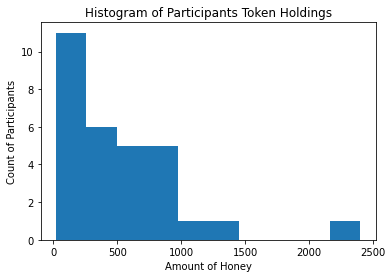

In [9]:
# Let's look at the distribution of participant holdings at the start of the sim
plt.hist([ state_variables['network'].nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')
plt.xlabel('Amount of Honey')
plt.ylabel('Count of Participants')


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Text(0.5, 1.0, 'Participants Social Network')

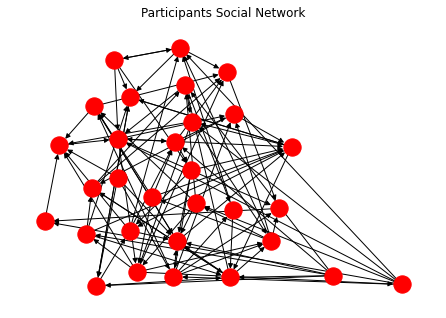

In [10]:
nx.draw_spring(state_variables['network'], nodelist = participants, edgelist=influencers)
plt.title('Participants Social Network')

In [11]:
#lets look at proposals
state_variables['network'].nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 2698.2388515058383,
 'trigger': inf}

Proposals initially start without any conviction, and with the status of a candidate. If the proposal's amount of  conviction is greater than it's trigger, then the proposal moves to active and it's funds requested are granted. 

All initial proposal start with 0 conviction and state 'candidate'we can simply examine the amounts of funds requested

In [12]:
funds_array = np.array([state_variables['network'].nodes[i]['funds_requested'] for i in proposals])
conviction_required = np.array([trigger_threshold(r, initial_values['funds'], initial_values['supply'], sim_config[0]['M']['alpha'],sim_config[0]['M']) for r in funds_array])

Text(0, 0.5, 'Amount of Honey requested(as a Fraction of Funds available)')

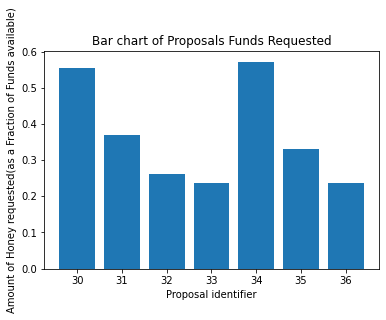

In [13]:
plt.bar( proposals, funds_array/initial_values['funds'])
plt.title('Bar chart of Proposals Funds Requested')
plt.xlabel('Proposal identifier')
plt.ylabel('Amount of Honey requested(as a Fraction of Funds available)')

Text(0, 0.5, 'Amount of Conviction')

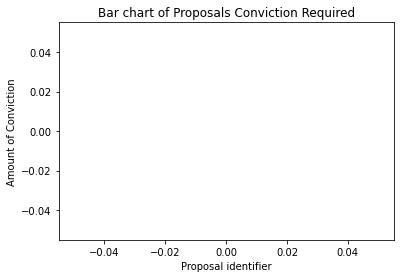

In [14]:
plt.bar( proposals, conviction_required)
plt.title('Bar chart of Proposals Conviction Required')
plt.xlabel('Proposal identifier')
plt.ylabel('Amount of Conviction')

Conviction is a concept that arises in the edges between participants and proposals in the initial conditions there are no votes yet so we can look at that later however, the voting choices are driven by underlying affinities which we can see now.

Text(0.5, 55.73999999999998, 'Participant_id')

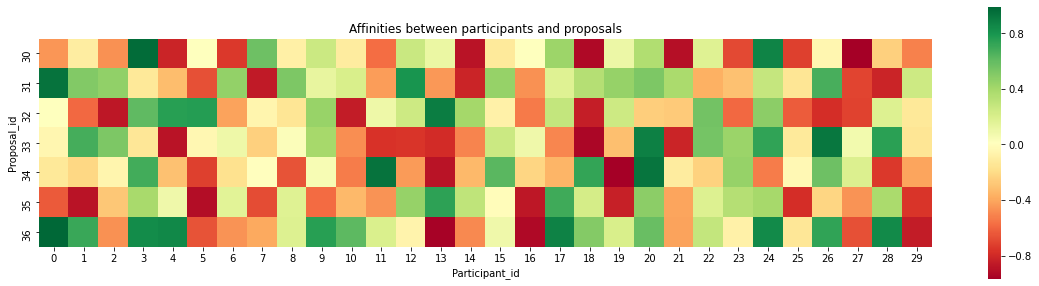

In [15]:
m = len(proposals)
n = len(participants)

affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = state_variables['network'].edges[(i,j)]['affinity']

dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            cmap = plt.cm.RdYlGn,
            ax=ax)

plt.title('Affinities between participants and proposals')
plt.ylabel('Proposal_id')
plt.xlabel('Participant_id')

## Run simulation

Now we will create the final system configuration, append the genesis states we created, and run our simulation.

In [16]:
from cadCAD.configuration import Experiment

# Create configuration
exp = Experiment()

exp.append_configs(
    sim_configs=sim_config,
    initial_state=state_variables,
    seeds=1,
    partial_state_update_blocks=partial_state_update_blocks
)

In [17]:
import numpy as np
import pandas as pd
from model import run
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

rdf = run.run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 11, 1, 9)
Execution Method: local_simulations
SimIDs   : [0, 1]
SubsetIDs: [0, 0]
Ns       : [0, 0]
ExpIDs   : [0, 0]
Total execution time: 326.79s


After the simulation has run successfully, we perform some postprocessing to extract node and edge values from the network object and add as columns to the pandas dataframe. For the rdf, we take only the values at the last substep of each timestep in the simulation.

In [18]:
df= run.postprocessing(rdf,0)

In [19]:
df.head(5)

,network,funds,sentiment,effective_supply,total_supply,fractionOfSupplyForVoting,fractionOfSupplyInPool,fractionOfProposalStages,fractionOfFundStages,simulation,...,age_all,conviction_all,triggers_all,conviction_share_of_trigger_all,percentageOfActiveProposals,percentageOfCompletedProposals,percentageOfKilledProposals,percentageOfActiveFundsRequested,percentageOfCompletedFundsRequested,percentageOfKilledFundsRequested
6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4889.60,0.60,14020.01,22414.61,0.63,4.58,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[1, 1, 1, 1, 1, 1, 1]","[72.9628948739454, 0.0, 0.0, 237.1959249033470...","[inf, inf, inf, inf, inf, inf, inf]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.00,0.43,0.00,0.00,0.38
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4912.02,0.60,14020.01,22437.03,0.62,4.57,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[2, 2, 2, 2, 2, 2, 2]","[900.3097153802602, 0.0, 0.0, 425.458455260418...","[inf, nan, nan, inf, inf, nan, inf]","[0.0, nan, nan, 0.0, 0.0, nan, 0.0]",0.00,0.00,0.43,0.00,0.00,0.38
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4934.45,0.60,14020.01,22459.46,0.62,4.55,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[3, 3, 3, 3, 3, 3, 3, 1, 1]","[1556.9753219873946, 0.0, 0.0, 810.60521531135...","[inf, nan, nan, inf, inf, nan, inf, 5563.19335...","[0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.217...",0.00,0.00,0.44,0.00,0.00,0.38
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4956.91,0.60,14240.84,22481.92,0.63,4.54,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1]","[2078.1711593471455, 0.0, 0.0, 1058.8147525782...","[inf, nan, nan, inf, inf, nan, inf, nan, 4780....","[0.0, nan, nan, 0.0, 0.0, nan, 0.0, nan, 0.436...",0.00,0.00,0.36,0.00,0.00,0.38
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4979.40,0.60,14240.84,22504.41,0.63,4.52,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[5, 5, 5, 5, 5, 5, 5, 3, 3, 2, 2, 1]","[2491.844569600303, 0.0, 0.0, 1249.12643758267...","[inf, nan, nan, inf, inf, nan, inf, nan, 4853....","[0.0, nan, nan, 0.0, 0.0, nan, 0.0, nan, 0.600...",0.00,0.00,0.42,0.00,0.00,0.38


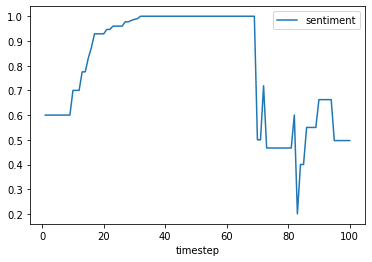

In [20]:
df.plot('timestep','sentiment')

The above plot demonstrates system sentiment changing over time as proposals pass or fail.

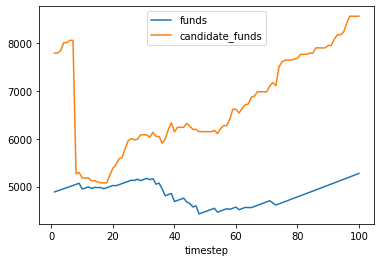

In [21]:
df.plot('timestep',['funds', 'candidate_funds'])

In the above graph, funds represent the total available funds, whereas candidate funds represent total funds requested by candidate proposals.

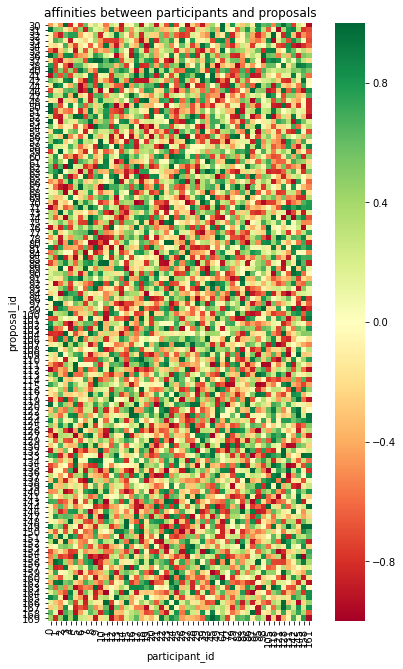

In [22]:
affinities_plot(df)

The above matrix represents participant affinities towards proposals, ranging from -1 to +1.

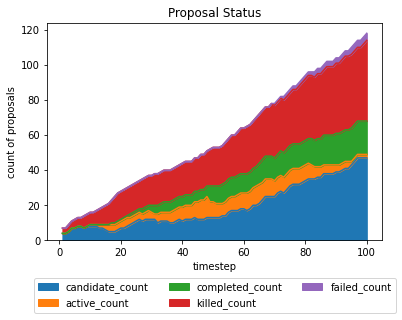

In [23]:
df.plot(x='timestep',y=['candidate_count','active_count','completed_count', 'killed_count', 'failed_count'],
         kind='area')
plt.title('Proposal Status')
plt.ylabel('count of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

The above graph shows the number of various types of proposals at a range of timesteps. Ecosystems with more completed proposals will have higher overall agent sentiment than systems with more failed and killed proposals.

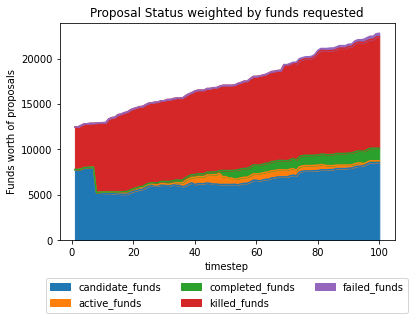

In [24]:
df.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds', 'killed_funds', 'failed_funds'], kind='area')
plt.title('Proposal Status weighted by funds requested')
plt.ylabel('Funds worth of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

The above graph shows the amount of funds requested by various types of proposals at a range of timesteps.

In [25]:
nets = df.network.values

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:569: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  

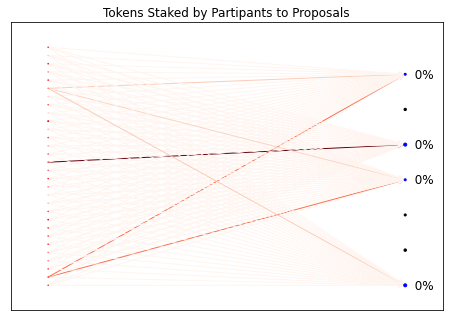

In [26]:
K = 0
N = 1

snap_plot(nets[K:N], size_scale = 1/300,savefigs=True)

On the left side are participants, with the right side of the graph being the proposals. With this graph, we can see the links between the participants and the proposals that they support. The percentage on the right hand are the the amount of the required amount to pass that has been fulfilled.

You can move the K and N to different points within the 100 timesteps, 0 indexed, to see how the model evolves overtime. 

As you can see with the plot above at the start of the simulation, no proposals have been formally supported yet. Below we can see a many interactions between agents and proposals.

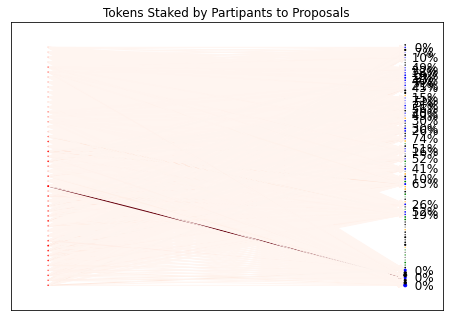

In [27]:
snap_plot(nets[80:81], size_scale = 1/300,savefigs=True)

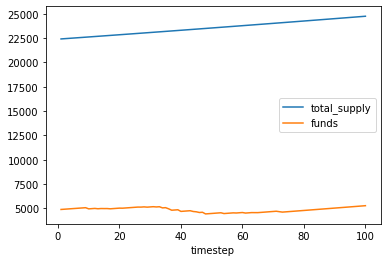

In [28]:
df.plot('timestep',['total_supply','funds'])

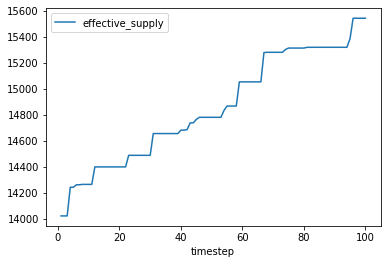

In [29]:
df.plot('timestep',['effective_supply'])

As expected *effective_supply* is increasing with the arrival of new participants.

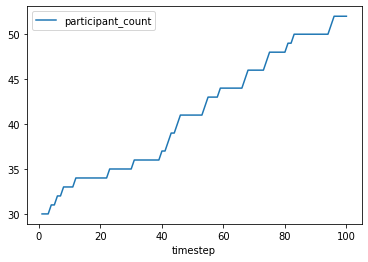

In [30]:
df.plot('timestep',['participant_count'])

## Review system health metrics

Below we will analysis system health metrics, such as fraction of supply used for voting, which is effective supply over total supply and percentage of proposals and requested funds in different stages. 

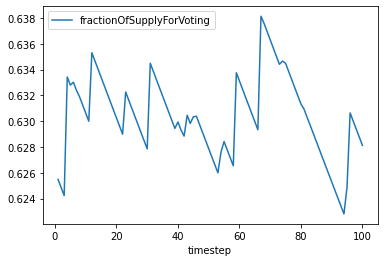

In [31]:
df.plot('timestep',['fractionOfSupplyForVoting'])

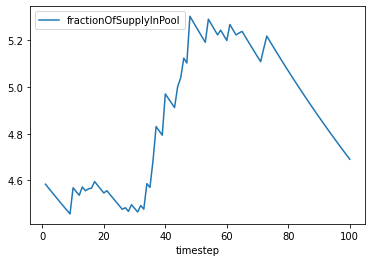

In [32]:
df.plot('timestep',['fractionOfSupplyInPool'])

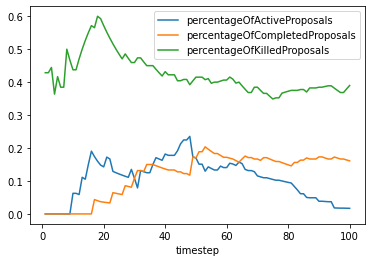

In [33]:
df.plot('timestep',['percentageOfActiveProposals','percentageOfCompletedProposals','percentageOfKilledProposals'])

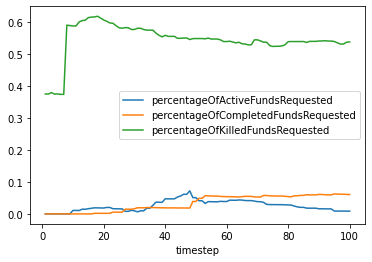

In [34]:
df.plot('timestep',['percentageOfActiveFundsRequested','percentageOfCompletedFundsRequested','percentageOfKilledFundsRequested'])

## Conclusion

We have created a conviction voting model that closely adheres to the 1Hive implementation. This notebook describes the use case, how the model works, and provides descriptions of how it fits together.